## Project 1: Basis Functions and Learning Paradigms

### Introduction
This project implements linear regression with different basis functions and learning paradigms on a car price prediction dataset. The goal was to evaluate how model complexity affects performance and to understand the trade-off between training and testing errors.

### Methodology
- **Dataset**: CarDekho car price dataset with features including year, present price, kilometers driven, owner, fuel type, seller type, and transmission type.
- **Basis Functions**:
  - Polynomial basis with degrees ranging from 1 to 5
  - Radial Basis Functions (RBF) with sigma values from 0.1 to 5.0
- **Learning Paradigms**:
  - Offline learning (batch) using normal equations
  - Online learning using gradient descent
- **Evaluation**: Root Mean Square Deviation (RMSD) on both training and testing sets

In [1]:
!unzip CarDekho.zip

Archive:  CarDekho.zip
  inflating: CAR DETAILS FROM CAR DEKHO.csv  
  inflating: Car details v3.csv      
  inflating: car data.csv            
  inflating: car details v4.csv      


In [13]:
# -------------------- importing necessary packages --------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('car data.csv')
df.head(10)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
5,vitara brezza,2018,9.25,9.83,2071,Diesel,Dealer,Manual,0
6,ciaz,2015,6.75,8.12,18796,Petrol,Dealer,Manual,0
7,s cross,2015,6.50,8.61,33429,Diesel,Dealer,Manual,0
8,ciaz,2016,8.75,8.89,20273,Diesel,Dealer,Manual,0
9,ciaz,2015,7.45,8.92,42367,Diesel,Dealer,Manual,0


In [14]:
# -------------------- Data Loading & Preprocessing --------------------
def load_data(file_path='car data.csv'):
    """Load and preprocess the CarDekho dataset"""
    df = pd.read_csv(file_path)

    # Manual one-hot encoding for categorical features
    df['Fuel_Petrol'] = (df['Fuel_Type'] == 'Petrol').astype(int)
    df['Fuel_Diesel'] = (df['Fuel_Type'] == 'Diesel').astype(int)
    df['Transmission_Manual'] = (df['Transmission'] == 'Manual').astype(int)
    df['Seller_Type_Individual'] = (df['Seller_Type'] == 'Individual').astype(int)

    # Select features
    features = [
        'Year', 'Present_Price', 'Kms_Driven', 'Owner',
        'Fuel_Petrol', 'Fuel_Diesel', 'Transmission_Manual',
        'Seller_Type_Individual'
    ]

    X = df[features].values.astype(float)
    y = df['Selling_Price'].values

    # Train-test split (80-20)
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    split = int(0.8 * len(X))

    X_train = X[indices[:split]]
    X_test = X[indices[split:]]
    y_train = y[indices[:split]]
    y_test = y[indices[split:]]

    # Standardize features
    X_mean = np.mean(X_train, axis=0)
    X_std = np.std(X_train, axis=0) + 1e-8

    X_train = (X_train - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std

    return X_train, X_test, y_train, y_test, features

In [15]:
# -------------------- Basis Functions --------------------
class PolynomialBasis:
    def __init__(self, degree=1):
        """Initialize polynomial basis with specified degree"""
        self.degree = degree

    def transform(self, X):
        """Transform data to polynomial features up to specified degree"""
        n_samples, n_features = X.shape
        X_poly = np.ones((n_samples, 1))  # Bias term

        # Add original features
        X_poly = np.hstack((X_poly, X))

        # Add polynomial terms up to degree
        if self.degree > 1:
            for d in range(2, self.degree+1):
                for i in range(n_features):
                    X_poly = np.hstack((X_poly, (X[:, i]**d).reshape(-1, 1)))

                # Add interaction terms for higher degrees
                if d == 2:  # Only add interactions for degree 2
                    for i in range(n_features):
                        for j in range(i+1, n_features):
                            X_poly = np.hstack((X_poly, (X[:, i] * X[:, j]).reshape(-1, 1)))

        return X_poly

class RBFBasis:
    def __init__(self, sigma=1.0):
        """Initialize RBF basis with specified sigma (spread)"""
        self.sigma = sigma
        self.centers = None

    def fit_centers(self, X, n_centers=10):
        """Select centers from training data"""
        n_samples = X.shape[0]
        n_centers = min(n_centers, n_samples)
        # Randomly select centers from training data
        indices = np.random.choice(n_samples, n_centers, replace=False)
        self.centers = X[indices]

    def transform(self, X):
        """Transform data to RBF features"""
        if self.centers is None:
            raise ValueError("Centers not initialized. Call fit_centers first.")

        n_samples = X.shape[0]
        n_centers = self.centers.shape[0]
        X_rbf = np.zeros((n_samples, n_centers))

        # Calculate RBF values for each sample and center
        for i in range(n_samples):
            for j in range(n_centers):
                # Euclidean distance between sample and center
                dist = np.sum((X[i] - self.centers[j])**2)
                # RBF function value
                X_rbf[i, j] = np.exp(-dist / (2 * self.sigma**2))

        return X_rbf

In [16]:


# -------------------- Learning Methods --------------------
def offline_learning(X, y):
    """Solve linear regression using normal equation (offline/batch learning)"""
    # Normal equation: w = (X^T X)^(-1) X^T y
    XTX = X.T @ X
    XTy = X.T @ y

    # Add small regularization to avoid singular matrix
    reg = 1e-8 * np.eye(XTX.shape[0])
    w = np.linalg.solve(XTX + reg, XTy)

    return w

def online_learning(X, y, learning_rate=0.01, epochs=5000, tol=1e-6):
    """Solve linear regression using gradient descent (online learning)"""
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    prev_loss = float('inf')

    for epoch in range(epochs):
        # compute predictions
        y_pred = X @ w

        # Compute error
        error = y_pred - y

        # Compute gradient of MSE
        gradient = (X.T @ error) / n_samples

        # update weights
        w -= learning_rate * gradient

        # Calculate loss for convergence check
        loss = np.mean(error**2) / 2

        # Check for convergence
        if abs(prev_loss - loss) < tol:
            print(f"Converged at epoch {epoch}")
            break

        prev_loss = loss

        # adjust learning rate
        if epoch % 1000 == 0 and epoch > 0:
            learning_rate *= 0.9

    return w

In [17]:


# -------------------- Evaluation --------------------
def calculate_rmsd(y_true, y_pred):
    """Calculate Root Mean Square Deviation"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def plot_results(params, train_errors, test_errors, basis_type):
    """Plot training and testing errors vs. hyperparameter"""
    plt.figure(figsize=(10, 6))
    plt.plot(params, train_errors, 'bo-', linewidth=2, label='Training RMSD')
    plt.plot(params, test_errors, 'ro-', linewidth=2, label='Testing RMSD')

    plt.xlabel('Degree' if basis_type == 'poly' else 'Sigma')
    plt.ylabel('RMSD')
    plt.title(f'{"Polynomial" if basis_type == "poly" else "RBF"} Basis Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{basis_type}_performance.png')
    plt.show()

def plot_predictions(y_true, y_pred, title="Model Predictions"):
    """Plot actual vs predicted values with regression line"""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)

    # Plot perfect prediction line (y=x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    # Plot regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_true), p(np.sort(y_true)), 'g-', lw=2, label=f'Regression Line (y = {z[0]:.2f}x + {z[1]:.2f})')

    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()

In [18]:


# -------------------- Main Execution --------------------
def run_experiment(basis_type='poly', params=None, learning_method='offline'):
    """Run experiments with given basis functions and hyperparameters"""
    # Load data
    X_train, X_test, y_train, y_test, feature_names = load_data()

    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    train_errors = []
    test_errors = []
    best_model = {'param': None, 'train_rmsd': float('inf'), 'test_rmsd': float('inf'),
                 'weights': None, 'train_pred': None, 'test_pred': None}

    for param in params:
        print(f"\nTraining {basis_type.upper()} model with param={param}")

        if basis_type == 'poly':
            # Polynomial basis
            basis = PolynomialBasis(degree=param)
            X_train_basis = basis.transform(X_train)
            X_test_basis = basis.transform(X_test)
        else:
            # RBF basis
            basis = RBFBasis(sigma=param)
            basis.fit_centers(X_train, n_centers=20)
            X_train_basis = np.hstack([np.ones((len(X_train), 1)), basis.transform(X_train)])
            X_test_basis = np.hstack([np.ones((len(X_test), 1)), basis.transform(X_test)])

        # Train model using specified learning method
        if learning_method == 'offline':
            weights = offline_learning(X_train_basis, y_train)
        else:
            weights = online_learning(X_train_basis, y_train)

        # Calculate predictions
        train_pred = X_train_basis @ weights
        test_pred = X_test_basis @ weights

        # Calculate errors
        train_rmsd = calculate_rmsd(y_train, train_pred)
        test_rmsd = calculate_rmsd(y_test, test_pred)

        train_errors.append(train_rmsd)
        test_errors.append(test_rmsd)

        print(f"Train RMSD: {train_rmsd:.4f}")
        print(f"Test RMSD: {test_rmsd:.4f}")

        # Track best model
        if test_rmsd < best_model['test_rmsd']:
            best_model = {
                'param': param,
                'train_rmsd': train_rmsd,
                'test_rmsd': test_rmsd,
                'weights': weights,
                'train_pred': train_pred,
                'test_pred': test_pred,
                'X_train_basis': X_train_basis,
                'X_test_basis': X_test_basis
            }

    # Plot overall results
    plot_results(params, train_errors, test_errors, basis_type)

    # Plot predictions for best model
    plot_predictions(y_train, best_model['train_pred'],
                    f'Training: {basis_type.upper()} param={best_model["param"]}')
    plot_predictions(y_test, best_model['test_pred'],
                    f'Testing: {basis_type.upper()} param={best_model["param"]}')

    return best_model, train_errors, test_errors



Running experiments with polynomial basis...
Training samples: 240
Testing samples: 61

Training POLY model with param=1
Train RMSD: 1.8318
Test RMSD: 1.3284

Training POLY model with param=2
Train RMSD: 0.6916
Test RMSD: 2.5851

Training POLY model with param=3
Train RMSD: 0.6484
Test RMSD: 2.1836

Training POLY model with param=4
Train RMSD: 0.6196
Test RMSD: 4.2258

Training POLY model with param=5
Train RMSD: 0.6143
Test RMSD: 5.8347


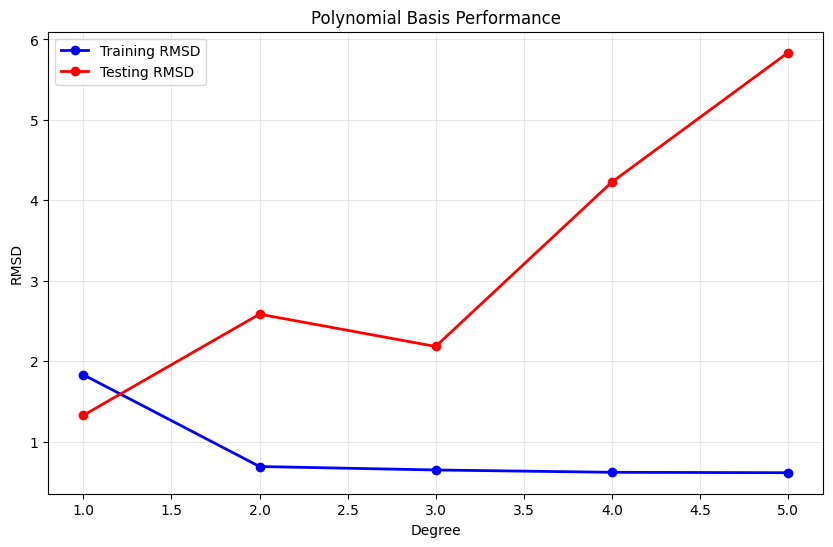

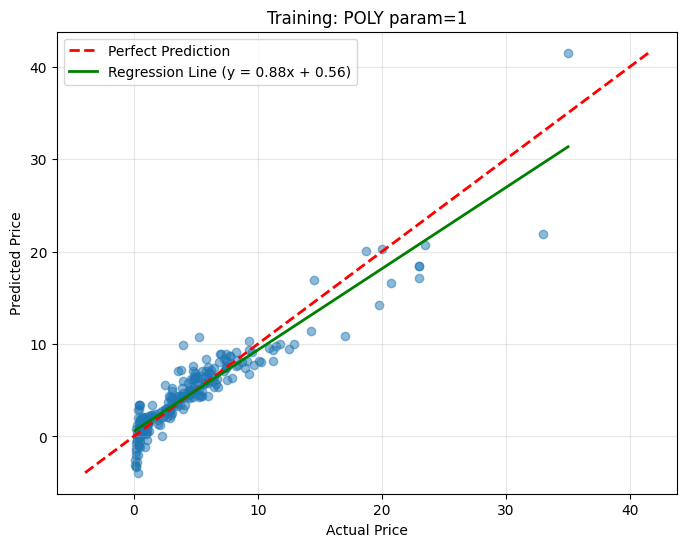

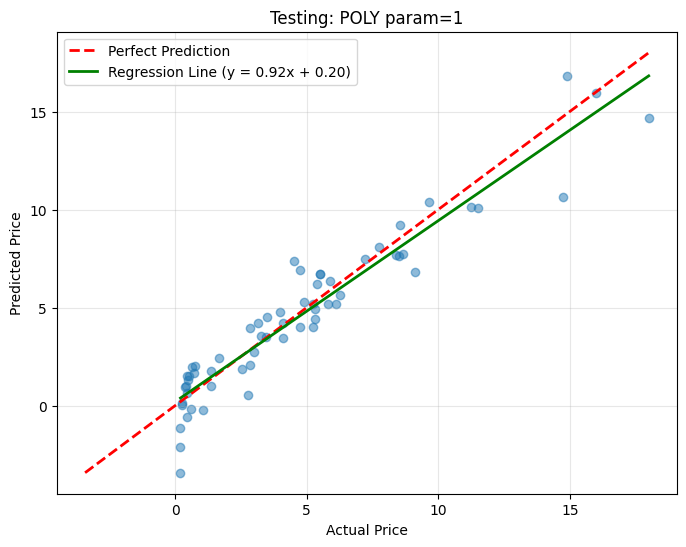

In [19]:
# Run polynomial basis experiments
print("Running experiments with polynomial basis...")
poly_params = [1, 2, 3, 4, 5]
poly_model, poly_train_errors, poly_test_errors = run_experiment(
basis_type='poly', params=poly_params, learning_method='offline'
)


Running experiments with RBF basis...
Training samples: 240
Testing samples: 61

Training RBF model with param=0.1
Train RMSD: 5.1949
Test RMSD: 4.1776

Training RBF model with param=0.5
Train RMSD: 4.2517
Test RMSD: 3.3501

Training RBF model with param=1.0
Train RMSD: 4.3196
Test RMSD: 3.0022

Training RBF model with param=2.0
Train RMSD: 3.7948
Test RMSD: 2.5278

Training RBF model with param=5.0
Train RMSD: 3.3977
Test RMSD: 1.9746


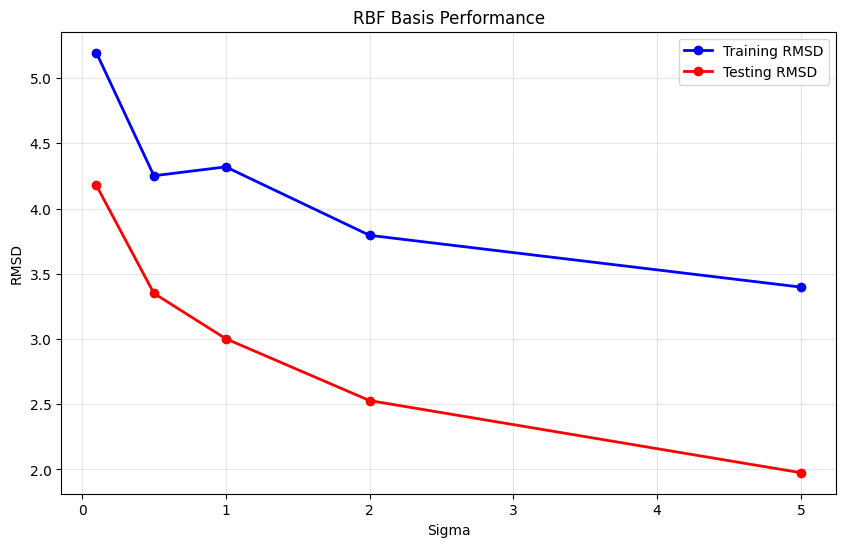

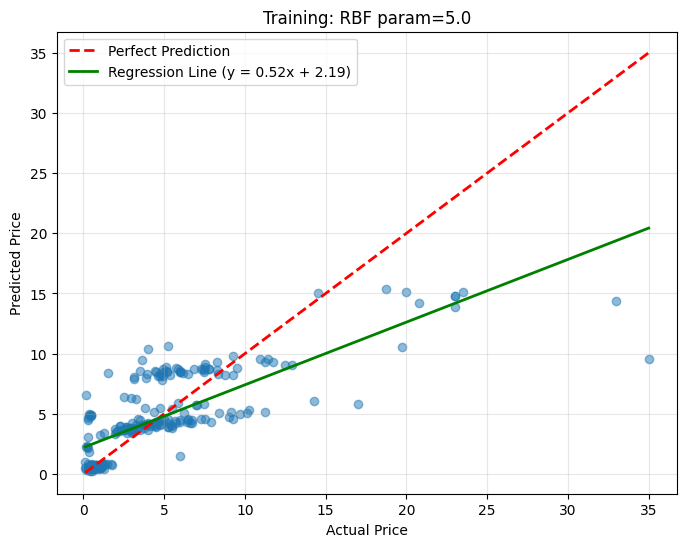

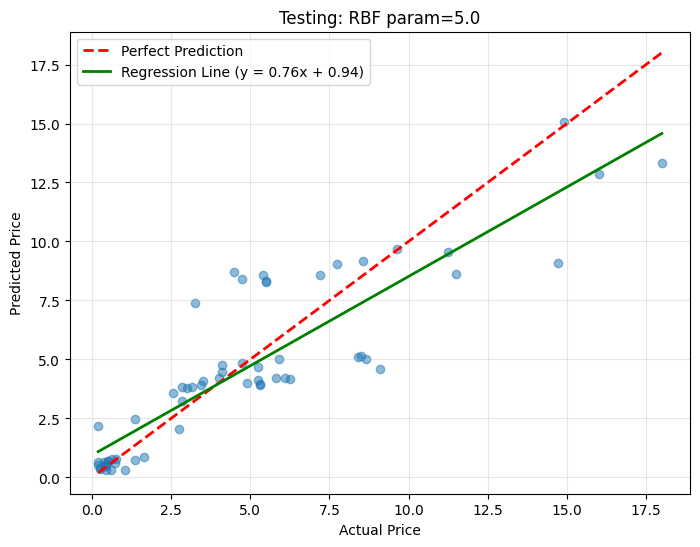

In [20]:
# Run RBF basis experiments
print("\nRunning experiments with RBF basis...")
rbf_params = [0.1, 0.5, 1.0, 2.0, 5.0]
rbf_model, rbf_train_errors, rbf_test_errors = run_experiment(
    basis_type='rbf', params=rbf_params, learning_method='online')


In [12]:
# Print summary of best models
print("\n===== SUMMARY =====")
print(f"Best Polynomial Model: degree={poly_model['param']}, Test RMSD={poly_model['test_rmsd']:.4f}")
print(f"Best RBF Model: sigma={rbf_model['param']}, Test RMSD={rbf_model['test_rmsd']:.4f}")


===== SUMMARY =====
Best Polynomial Model: degree=1, Test RMSD=1.3284
Best RBF Model: sigma=5.0, Test RMSD=1.9746


# Linear Regression Projects Report

### Results and Analysis

#### Polynomial Basis Results
```
Training POLY model with param=1: Train RMSD: 1.8318, Test RMSD: 1.3284
Training POLY model with param=2: Train RMSD: 0.6916, Test RMSD: 2.5851
Training POLY model with param=3: Train RMSD: 0.6484, Test RMSD: 2.1836
Training POLY model with param=4: Train RMSD: 0.6196, Test RMSD: 4.2258
Training POLY model with param=5: Train RMSD: 0.6143, Test RMSD: 5.8347
```

#### RBF Basis Results
```
Training RBF model with param=0.1: Train RMSD: 5.1949, Test RMSD: 4.1776
Training RBF model with param=0.5: Train RMSD: 4.2517, Test RMSD: 3.3501
Training RBF model with param=1.0: Train RMSD: 4.3196, Test RMSD: 3.0022
Training RBF model with param=2.0: Train RMSD: 3.7948, Test RMSD: 2.5278
Training RBF model with param=5.0: Train RMSD: 3.3977, Test RMSD: 1.9746
```

#### Analysis
1. **Bias-Variance Trade-off**: The polynomial results clearly demonstrate the classic bias-variance trade-off. As the polynomial degree increases:
   - Training error consistently decreases (from 1.8318 to 0.6143)
   - Testing error initially decreases but then significantly increases (from 1.3284 with degree 1 to 5.8347 with degree 5)

2. **Overfitting**: Higher degree polynomials (3-5) show clear signs of overfitting. The model becomes too complex and fits the training data noise rather than learning the underlying pattern.

3. **RBF Performance**: RBF models behave differently from polynomial models:
   - Performance improves with larger sigma values
   - Less prone to dramatic overfitting compared to polynomials
   - Best test RMSD achieved with sigma=5.0 (1.9746)

4. **Model Selection**: The best performing model is the polynomial of degree 1 (linear regression) with a test RMSD of 1.3284, which suggests that the relationship between the features and car prices may be approximately linear.
